In [30]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms 

from PIL import Image
import matplotlib.pyplot as plt

from sklearn.linear_model import SGDClassifier
import numpy as np

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve

In [3]:
mnist_train_set = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_test_set = datasets.MNIST(root='./data', train=False, download=True, transform=None)

In [4]:
len(mnist_train_set)

60000

In [5]:
type(mnist_train_set)

torchvision.datasets.mnist.MNIST

In [6]:
mnist_train_set[0], mnist_train_set[1]

((<PIL.Image.Image image mode=L size=28x28>, 5),
 (<PIL.Image.Image image mode=L size=28x28>, 0))

In [7]:
first_img, first_target = mnist_train_set[0]

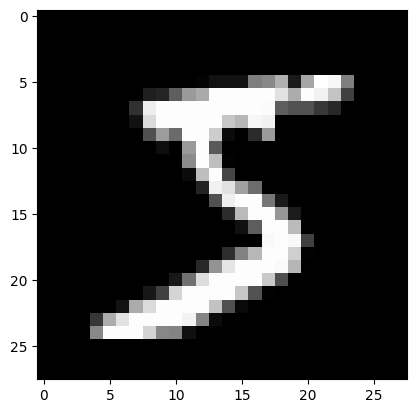

In [8]:
plt.imshow(first_img, cmap='gray')
plt.show()

In [9]:
first_target

5

### SGD Classifier for 5 or not 5

In [10]:
# picking a random image
i = np.random.randint(len(mnist_train_set))
print(i)

48964


In [11]:
x_train = np.array([
    np.array(img).reshape(-1) for img, label in mnist_train_set])
x_test = np.array([
    np.array(img).reshape(-1) for img, label in mnist_test_set])

y_train = np.array([label == 5 for _, label in mnist_train_set])
y_test = np.array([label == 5 for _, label in mnist_test_set])
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(60000, 784) (60000,) (10000, 784) (10000,)


In [12]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(x_train, y_train)

,loss,'hinge'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [13]:
# some random digit
rndm_dgt, its_label = mnist_train_set[i]
y_pred = sgd_clf.predict(np.array([np.array(rndm_dgt).reshape(-1)]))

In [14]:
y_pred

array([False])

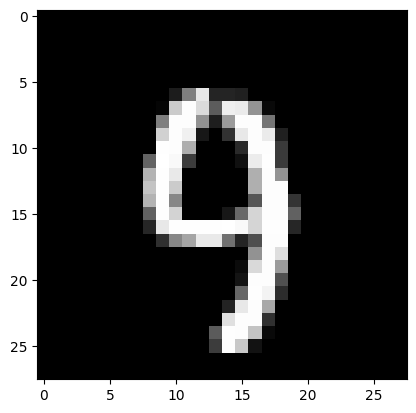

In [15]:
plt.imshow(rndm_dgt, cmap='gray')
plt.show()

In [16]:
# metrics
scre = cross_val_score(sgd_clf, x_train, y_train, cv=3, scoring="accuracy")
print(scre)
y_train_pred = cross_val_predict(sgd_clf, x_train, y_train, cv=3)

[0.95035 0.96035 0.9604 ]


## Note:
- This is a dumb classifier as it only, showcases not 5. Provided we have data which is skewed, accuracy isn't a good metrics to be happy with.


In [17]:
confusion_matrix(y_train, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [18]:
precision_score(y_train, y_train_pred)

0.8370879772350012

In [19]:
recall_score(y_train, y_train_pred)

0.6511713705958311

In [21]:
 f1_score(y_train, y_train_pred)

0.7325171197343847

In [24]:
# decision function
y_scores = sgd_clf.decision_function(np.array([np.array(rndm_dgt).reshape(-1)]))
y_scores

array([-4896.05074288])

In [25]:
y_scores = cross_val_predict(sgd_clf, x_train, y_train, cv=3, method='decision_function')

In [27]:
precision, recall, thresholds = precision_recall_curve(y_train, y_scores)

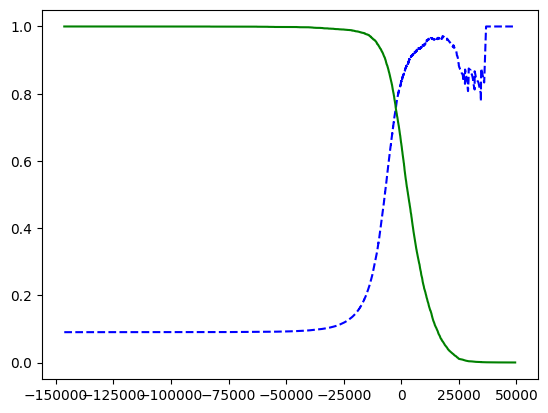

In [28]:
plt.plot(thresholds, precision[:-1], "b--", label="Precision")
plt.plot(thresholds, recall[:-1], "g-", label="Recall")
plt.show()

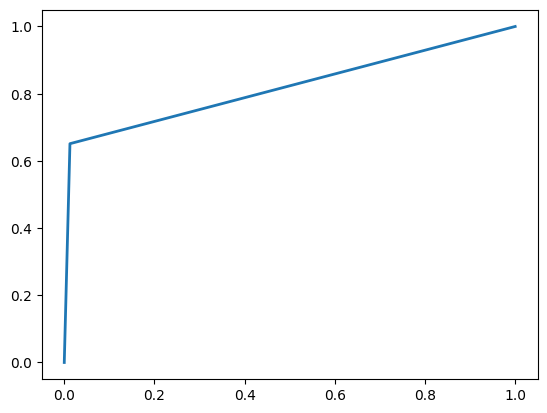

In [31]:
# ROC Curve
fpr, tpr, thresh = roc_curve(y_train, y_train_pred)

plt.plot(fpr, tpr, linewidth=2)
plt.show()